# Ajuste de las curvas obtenidas en el transitorio del circuito RCL Crítico

En este tutorial analizo los datos adquiridos de un circuito **RLC transitorio crítico**.

El circuito tiene las siguientes características:

```
 _____ -V0 (PULSE)+ _____ R _____ L _____ C ____   
|                     |               |         |  
GND                  Vin              VC        GND
```

Parámetros:
- R = 2 $k\Omega$
- L = 100 $mH$
- C = 100 $nF$

- Tiempo característico $\tau = 2L/R \approx 0.0001$ sec
- $V_0$ tren de pulsos cuadrados, tension en alto $5V$. Tiempo de alto y tiempo de bajo $10\tau$
- En $V_{in}$ se mide la señal de entrada respecto de GND (masa).
- En $V_C$ se mide la tensión en el capacitor respecto de GND (masa).

Empezamos importando las librerías necesarias:

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

Cargamos los datos

In [21]:
df = pd.read_csv("datos/data_RLC_critico.csv")

df.head()

,time,Vin,VC,I
0,0.000000e+00,-0.004517,-0.030526,5.209502e-08
1,1.428571e-10,0.715972,0.015663,2.360429e-06
2,2.857143e-10,1.433148,0.023521,-7.645043e-07
3,4.285714e-10,2.127252,0.015965,-4.490775e-07
4,5.714286e-10,2.859388,0.015971,-7.206572e-07


Hacemos un plot exploratorio:

<Axes: xlabel='time'>

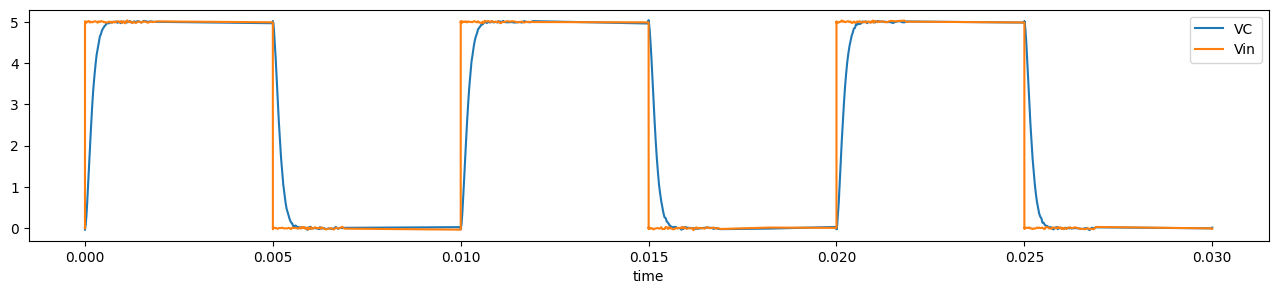

In [22]:
df.plot( x='time', y=['VC', 'Vin'], figsize=(16,3) )

**Filtramos** los datos para quedarnos solo con uno de transitorios. Nos quedamos con el que esta entre los tiempos 0.010 y 0.015:

<Axes: xlabel='time'>

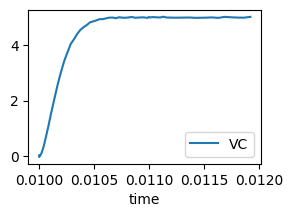

In [23]:
df_alto = df[ (df["time"]<0.015) & (df["time"]>0.010) ]

df_alto.plot(x='time', y='VC', figsize=(3,2))

El eje temporal esta trasladado, **llevamos el origen a cero** restando el primer punto, tambien pasamos nuestros datos a arrays de numpy para trabajar más cómodos el ajuste:

In [24]:
t0 = df_alto["time"].iloc[0]

t = df_alto["time"].to_numpy()-t0

VC = df_alto["VC"].to_numpy()

Definimos una **ecuación** para hacer el ajuste de la tensión que cae en los bornes del capacitor:

$$
V_C = V_0 ( 1 - e^{-\gamma t} ( 1 + \gamma t  ) )
$$

In [25]:
def modelo_tension(u, V0, g):                         
    z= V0*( 1 - np.exp(-g*u)*( 1 + g*u ) )    # Ec para la tensión VC caso sub amort
    return z


Estimamos los valores de los parámeros para pasarselos al algoritmo como **semillas**:

In [29]:
R= 2000
L= 100e-3
C= 100e-9

g = R/(2.0*L)
w02 = 1.0/(L*C)
w2 = w02 - g**2

print ("Amortiguamiento teórico: ", g)
print ("Freq angular teórica (es cero por estar en estado crítico): ", w2)

Amortiguamiento teórico:  10000.0
Freq angular teórica (es cero por estar en estado crítico):  0.0


**Ajuste**:

In [27]:
# valores semilla
V0_ini = 5.0
g_ini  = 10000.0

# ajuste
popt, pcov = curve_fit(modelo_tension, t, VC, p0=[ V0_ini, g_ini ] )      

# tomo parámetros
V0, g = popt

# Errores estandar
SE_V0, SE_g = np.sqrt(np.diag(pcov))

print ("Parámetros obtenidos del ajuste:")
print(f"V0 = ({V0:.4f} ± {SE_V0:.4f})")
print(f"g  = ({g:.4f} ± {SE_g:.6f})")

Parámetros obtenidos del ajuste:
V0 = (5.0102 ± 0.0034)
g  = (10356.9815 ± 29.910969)


Hacemos un **plot** con los datos del experimento y el ajuste:

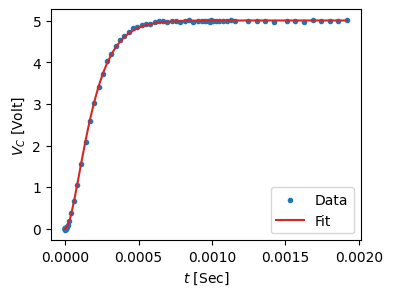

In [28]:
fig,ax = plt.subplots(figsize=(4,3))

ax.scatter( t, VC ,label='Data', marker='.')                      # datos

ax.plot( t, modelo_tension(t, V0, g), c='C3', label='Fit' )       # modelo con parametros del ajuste

ax.set_xlabel("$t$ [Sec]")
ax.set_ylabel("$V_C$ [Volt]")

plt.legend(loc=4)
plt.show()